## Code Modules & Functions

In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xm7cb9ei
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-xm7cb9ei
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0efada87670dec4e6d06bbd9db39bd38f13bad1a5_-py3-none-any.whl size=124647 sha256=b9e9f09ad38869bc81f25a23aa29166aa43c7b1e2f444f9a03ac7c1a50471fb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-mckjllmr/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,tensorflow as tf
import h5py,imageio,os
import seaborn as sn,pylab as pl
from keras.preprocessing import image as kimage
from tensorflow_docs.vis import embed
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True 
fpath='../input/tomato-cultivars/'

Using TensorFlow backend.


In [3]:
def path_to_tensor(img_path,fpath=fpath):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(160,160))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths):
    tensor_list=[path_to_tensor(img_path) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
def animate(images):
    converted_images=np.clip(images*255,0,255)\
    .astype(np.uint8)
    imageio.mimsave('animation.gif',converted_images)
    return embed.embed_file('animation.gif')
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1)
    v2norm=tf.norm(v2)
    v2normalized=v2*(v1norm/v2norm)
    vectors=[]
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-1)
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=\
        interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

In [4]:
def plcmap(cmap,n):
    return [pl.cm.get_cmap(cmap)(i/n)[:3] 
            for i in range(1,n+1)]
plcmap('Reds',5)

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),
 (0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
 (0.9466666666666667, 0.26823529411764707, 0.19607843137254902),
 (0.7364705882352941, 0.08, 0.10117647058823528),
 (0.403921568627451, 0.0, 0.05098039215686274)]

## Data Processing

In [5]:
names=['Kumato','Beefsteak','Tigerella',
       'Roma','Japanese Black Trifele',
       'Yellow Pear','Sun Gold','Green Zebra',
       'Cherokee Purple','Oxheart','Blue Berries',
       'San Marzano','Banana Legs',
       'German Orange Strawberry','Supersweet 100']
flist=sorted(os.listdir(fpath))
labels=np.array([int(el[:2]) for el in flist],
               dtype='int32')-1
images=np.array(paths_to_tensor(flist),
                dtype='float32')/255
N=labels.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_train=images[:n],images[n:]
y_test,y_train=labels[:n],labels[n:]

100%|██████████| 776/776 [00:03<00:00, 221.70it/s]


In [6]:
pd.DataFrame([[x_train.shape,x_test.shape],
              [x_train.dtype,x_test.dtype],
              [y_train.shape,y_test.shape],
              [y_train.dtype,y_test.dtype]],               
             columns=['train','test'])

train                test
0  (621, 160, 160, 3)  (155, 160, 160, 3)
1             float32             float32
2              (621,)              (155,)
3               int32               int32

In [7]:
with h5py.File('TomatoCultivarImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train)
    f.create_dataset('train_labels',data=y_train)
    f.create_dataset('test_images',data=x_test)
    f.create_dataset('test_labels',data=y_test)
os.stat('TomatoCultivarImages.h5')

os.stat_result(st_mode=33188, st_ino=131083, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=238394400, st_atime=1594835624, st_mtime=1594835624, st_ctime=1594835624)

## Data Representation

In [8]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

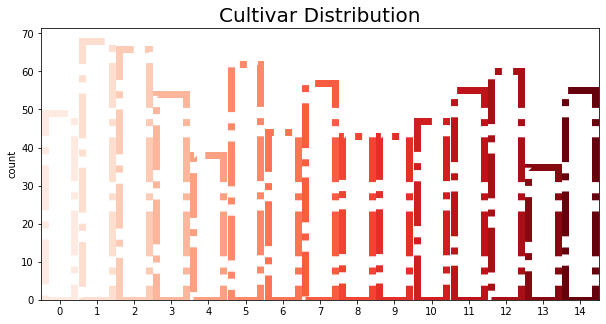

In [9]:
pl.figure(figsize=(10,5))
sn.countplot(x=labels,facecolor=(0,0,0,0),
             linewidth=7,linestyle='-.',
             edgecolor=plcmap('Reds',15))
pl.title('Cultivar Distribution',fontsize=20);

Label:  3 Roma


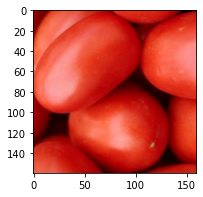

In [10]:
n=np.random.randint(40)
print('Label: ',y_test[n],
      names[y_test[n]])
pl.figure(figsize=(3,3))
pl.imshow((x_test[n]));


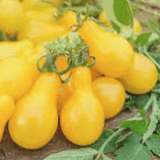

In [11]:
imgs=interpolate_hypersphere(x_train[0],x_train[1],180)
animate(imgs)